In [1]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
require("pacman")
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

Loading required package: pacman



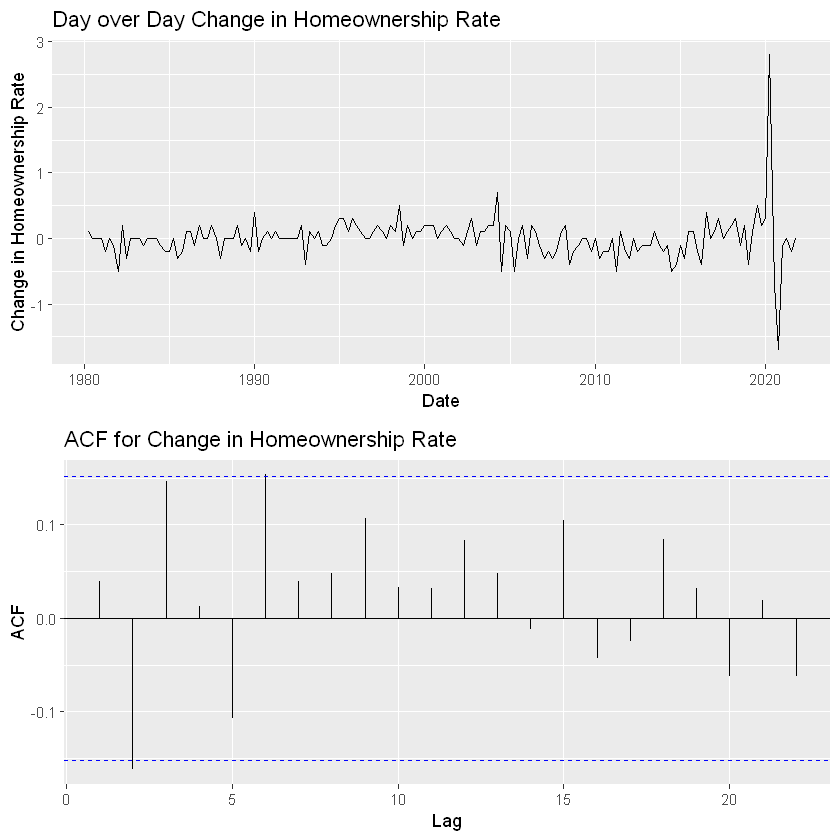

In [2]:
homeownership <- read_homeownership()
homeownership <- homeownership %>% mutate(dValue = Value - lag(Value)) %>% drop_na

p1 <- homeownership %>% ggplot() +
    geom_line(aes(x = Date, y = dValue)) +
    labs(y = "Change in Homeownership Rate", title = "Day over Day Change in Homeownership Rate")
p2 <- ggAcf(homeownership$dValue) + 
    labs(title = "ACF for Change in Homeownership Rate")
ggarrange(p1, p2, nrow = 2, ncol = 1)

In [3]:
train <- head(homeownership, -4)
test <- tail(homeownership, 4)
arima_fit <- fit_arima(training_data = train$dValue, p_range = 0:5, d_range = 0:2, q_range = 0:5)
head(arima_fit)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,0,4,86.75047
2,5,1,5,92.20482
3,5,1,1,92.86274
4,5,1,2,94.36783
5,3,0,3,95.55478
6,2,1,4,95.75151



	Box-Ljung test

data:  residuals(model)
X-squared = 1.71, df = 1, p-value = 0.191


	Box-Ljung test

data:  residuals(model)^2
X-squared = 3.5214, df = 1, p-value = 0.06058



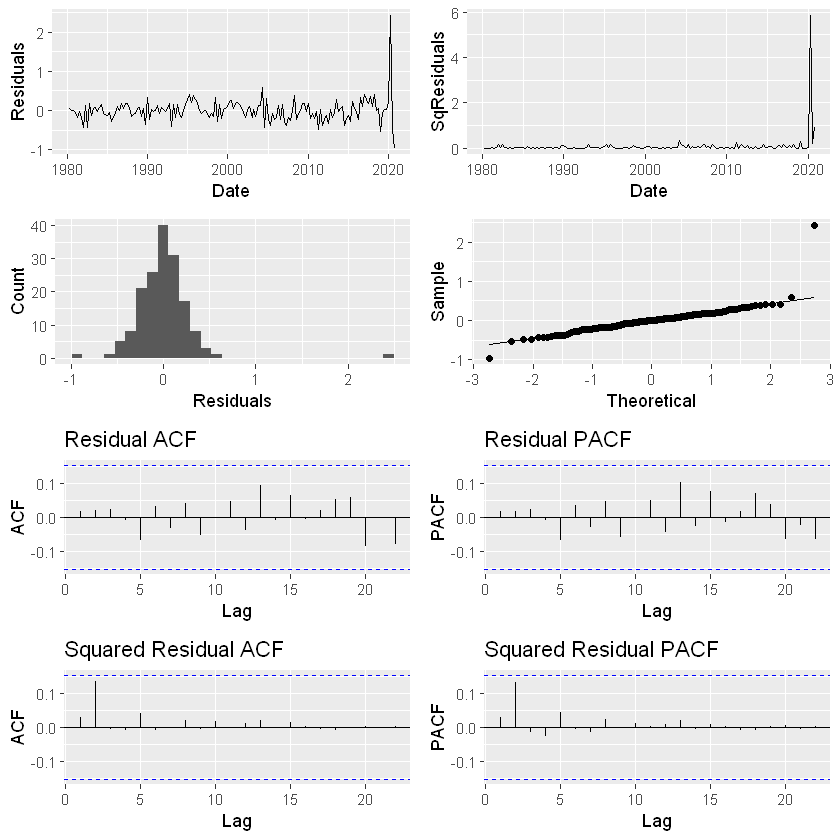

In [4]:
suppressWarnings(arima_model <- arima(train$dValue, order = c(4,0,4), method = "ML"))
residual_analysis(arima_model, train$Date)
box_tests(arima_model, 8)

In [5]:
arma_garch_fit <- fit_ugarch(train$dValue, 4, 4, 0:5, 0:5, 0:2, 0:2)
head(arma_garch_fit$Final)

,p,q,m,n,BIC
,<int>,<int>,<int>,<int>,<dbl>
1,4,4,1,2,-0.09431624
2,4,4,1,0,-0.03610705
3,4,4,2,1,0.01896037
4,4,4,0,1,0.04214350
5,4,4,2,0,0.04580323
6,4,4,1,1,0.05282007



	Box-Ljung test

data:  residuals(model)
X-squared = 15.688, df = 1, p-value = 7.47e-05


	Box-Ljung test

data:  residuals(model)^2
X-squared = 36.814, df = 1, p-value = 1.3e-09



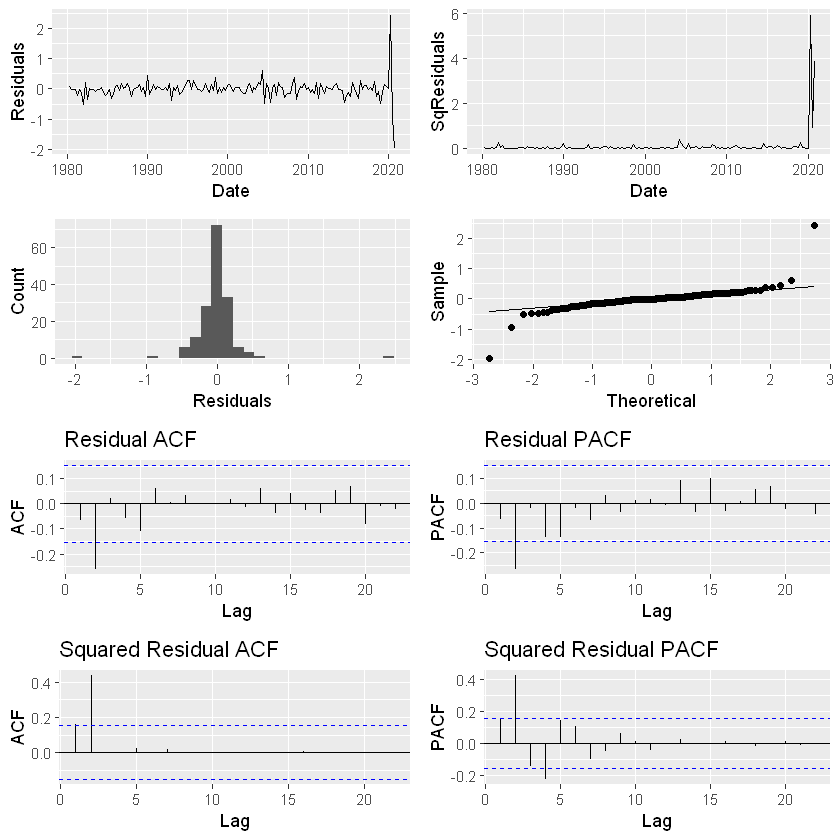

In [6]:
spec <- ugarchspec(variance.model=list(garchOrder=c(1,2)),
                     mean.model=list(armaOrder=c(4,4),
                                     include.mean=T), distribution.model="std")
suppressWarnings(ugarch_model1 <- ugarchfit(spec, train$dValue, solver = 'hybrid'))
residual_analysis(ugarch_model1, train$Date)
box_tests(ugarch_model1, 11)

PM =  90.86929

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.5155704,0.7903963,0.7365334,-Inf,Inf


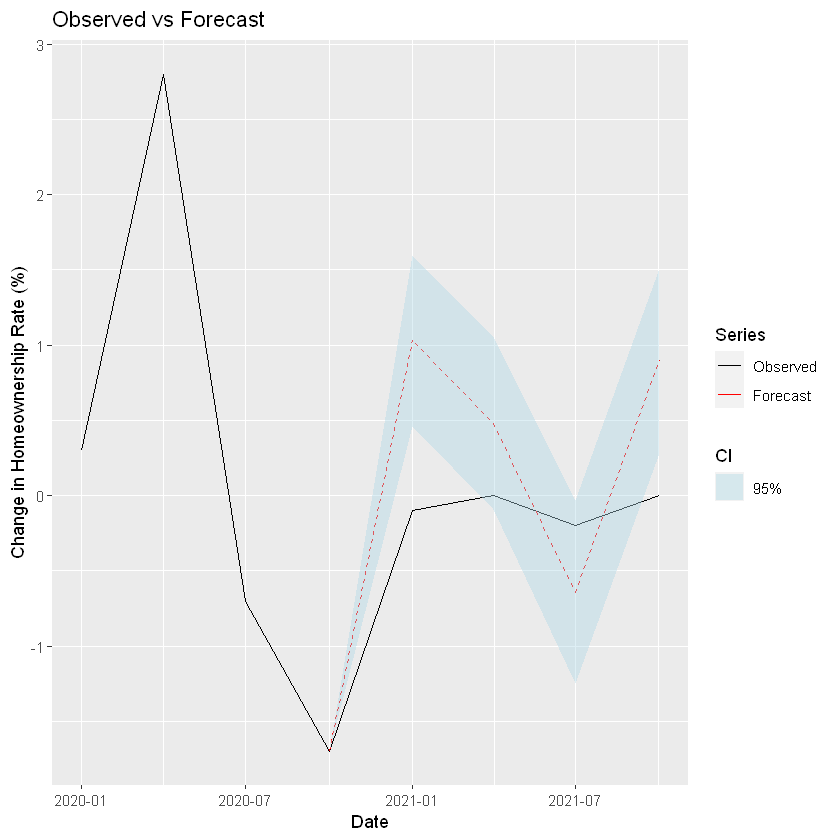

In [7]:
fc <- forecast_arima(arima_model, homeownership$Date, test$dValue, 4, 95,
                    y_lab = "Change in Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  19.03436

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.3417168,0.3617474,0.3417168,-Inf,Inf


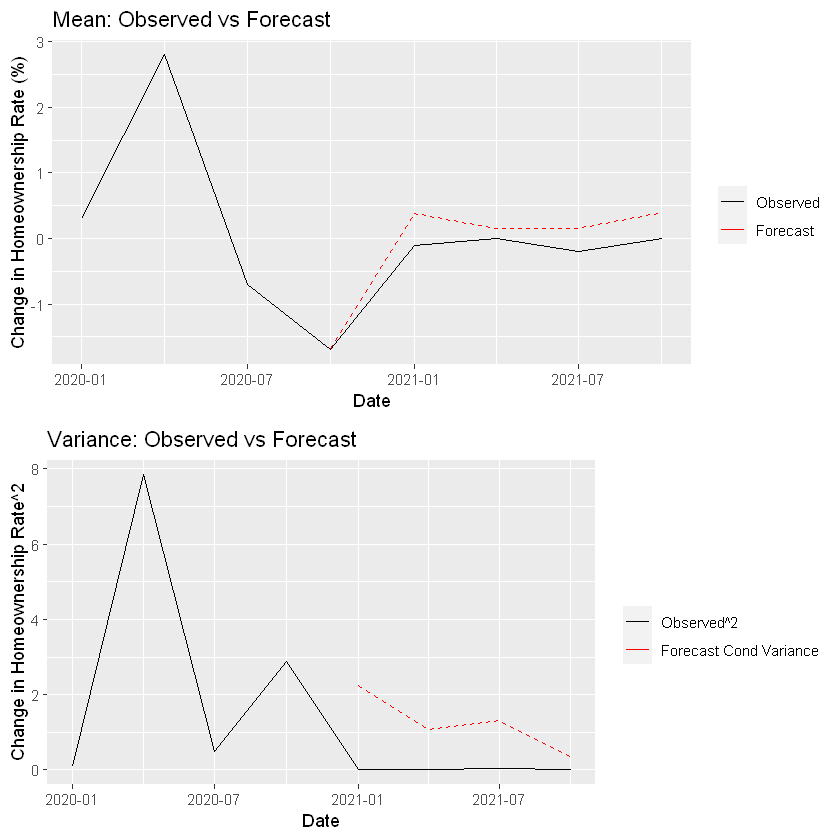

In [8]:
fc <- forecast_ugarchroll(ugarch_model1, homeownership$Date, test$dValue, 4,
                          y_lab = c("Change in Homeownership Rate (%)", "Change in Homeownership Rate^2"))
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)